**Chapter 4**
learning CNN's 

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset,TensorDataset,DataLoader

In [ ]:
from torch.optim import Adam, sgd
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np
import matplotlib.pyplot  as plt
%matplotlib inline

In [ ]:
X_train = torch.tensor(
    [[
        [[1,2,3,4],[2,3,4,5],[3,4,5,6],[3,4,5,7]]
    ],
    [
        [[1,2,3,4],[2,3,44,5],[3,4,5,2],[3,4,5,7]]
    ]]
).to(device).float()

In [ ]:
X_train/=8
y_train = torch.tensor([0,1]).to(device).float()

In [ ]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1,1,kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1,1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(),1e-3)
    return model,loss_fn,optimizer

In [ ]:
from torchsummary import summary
model, loss_func,optimizer = get_model()
summary(model,X_train)

In [ ]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction.squeeze(0),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()
    

In [ ]:
train_dl = DataLoader(TensorDataset(X_train,y_train))

In [ ]:
for epoch in range(500):
    for ix,batch in enumerate(iter(train_dl)):
        x,y = batch
        batch_loss = train_batch(x,y,model=model,opt=optimizer,loss_fn=loss_func)

In [ ]:
model(X_train[-1])

In [ ]:
y[-1]

## Classifying FMNIST images Using CNN

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data_folder = './data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,download=True, train=True)
fmnist_images = fmnist.data
fmnist_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder,download=False, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets




In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x,self.y = x,y
    def __getitem__(self,ix):
        return self.x[ix],self.y[ix]
    def __len__(self):
        return len(self.x)

In [ ]:
from torch.optim import SGD,Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1,64,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200,256),
        nn.ReLU(),
        nn.Linear(256,10)
    )
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(),lr=1e-3)
    return model,loss_func,optimizer

In [ ]:
from torchsummary import summary

model,loss_fn,optimizer = get_model()
summary(model,torch.zeros(1,1,28,28))

In [ ]:
def get_data():
    train_ds = FMNISTDataset(fmnist_images,fmnist_targets)
    trn_dl = DataLoader(train_ds,batch_size=1000,shuffle=True)

    val_ds = FMNISTDataset(val_images,val_targets)
    val_dl = DataLoader(val_ds,batch_size=len(val_ds),shuffle=True)

    return trn_dl,val_dl

In [ ]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction.squeeze(0),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()
    

In [ ]:
@torch.no_grad
def validate(x,y,model,loss_fn):
    model.eval()
    prediction = model(x)
    batch_loss = loss_fn(prediction,y)
    maxval,maxarg = prediction.max(-1)
    is_correct = maxarg == y
    return  torch.mean(is_correct.float()),batch_loss.item()

In [ ]:
trn_dl,val_dl = get_data()
model,loss_fn,optimizer = get_model()
epoch_losses = []
validation_loss_epoch = []

training_accuracies ,training_losses =[],[]
validation_accuracies,validation_losses = [],[]
for epoch in range(3):
    for ix,batch in enumerate(iter(trn_dl)):
        x,y = batch
        batch_loss = train_batch(x,y,model=model,opt=optimizer,loss_fn=loss_fn)
        batch_accuracy ,batch_loss = validate(x,y,model,loss_fn)
        print(f'epoch number is {epoch}\n\t ix: {ix}')
    training_losses.append(np.mean(batch_loss))
    training_accuracies.append(batch_accuracy)
    for ix,batch in enumerate(iter(val_dl)):
        x,y = batch
        validation_accuracy,validation_loss = validate(x,y,model=model,loss_fn=loss_fn)
        print(f'epoch number is {epoch}\n\t ix inside dataloader: {ix}\n\tbatch_loss:{batch_loss}\n\tevaluation_result')
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

epochs = np.arange(3) + 1
plt.subplot(211)
plt.plot(epochs,training_losses,'bo',label = 'Training Loss')
plt.plot(epochs,validation_losses, label = 'Validation Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


plt.subplot(212)
plt.plot(epochs,training_accuracies,'bo',label = 'Training Loss')
plt.plot(epochs,validation_accuracies, label = 'Validation Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('off')
plt.show()

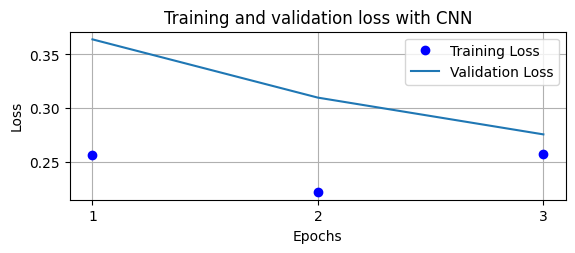

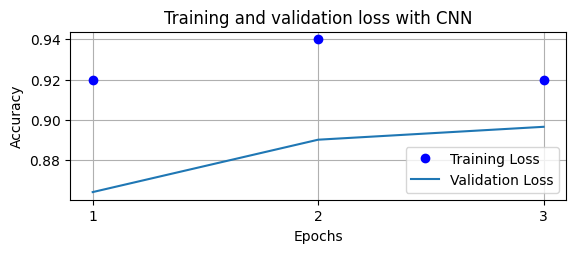

## Dogs and Cats Problem

In [8]:
PATH='./data/archive'
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms,datasets,models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch import optim;device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [9]:
training_set = './data/archive/training_set/training_set/'
test_set = './data/archive/test_set/test_set/'

In [10]:
class cat_dogs:
    def __init__(self,folder):
        cats = glob(folder +'/cats/*.jpg')
        dogs = glob(folder + '/dogs/*.jpg')
        self.fpaths = cats + dogs
        from random import random,seed,shuffle;seed(10)
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog')\
                         for fpath in self.fpaths]
        

    def __len__(self):
        return len(self.fpaths)
    def __getitem__(self,ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:,:,::-1]
        im = cv2.resize(im,(224,224))
        #permutation is important!
        return torch.tensor(im/224).permute(2,0,1).float().to(device),\
                torch.tensor(target).float().to(device)
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.)


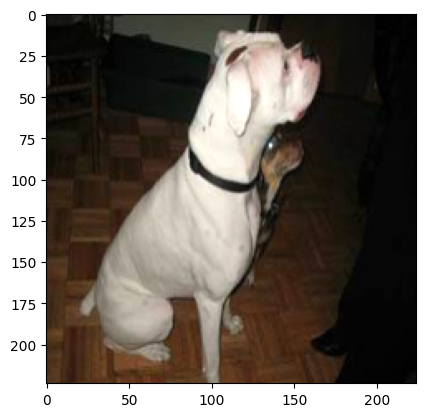

In [12]:
dataset = cat_dogs(training_set)
data, label = dataset[10]

#permutation is important
plt.imshow(data.permute(1,2,0))
print(label)


In [13]:
def conv_layer(ni,no,kernel_size ,stride = 1):
    return nn.Sequential(
        nn.Conv2d(ni,no,kernel_size,stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )

In [14]:
def get_model():
    model = nn.Sequential(
        conv_layer(3,64,3),
        conv_layer(64,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        nn.Flatten(),
        nn.Linear(512,1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    return model,loss_fn,optimizer

In [15]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [16]:
def get_data():
    train_ds = cat_dogs(training_set)
    train_dl = DataLoader(train_ds,batch_size=32,shuffle=True,drop_last=True)

    val_ds = cat_dogs(test_set)
    val_dl = DataLoader(val_ds,batch_size=len(val_ds),shuffle=True,drop_last=True)
    return train_dl,val_dl

In [17]:
def train_batch(input,real_output,mdoel,loss_fn,optimizer):
    model.train()
    predicted_output = model(input)
    print(predicted_output.shape)
    print(real_output.shape)
    loss = loss_fn(predicted_output.view(real_output.shape),real_output)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

In [18]:
@torch.no_grad()
def calculate_accuracy(input,real_output,model):
    predicted_output = model(input)
    is_correct = (predicted_output >=.5) == real_output
    return is_correct.cpu().float().numpy().tolist()

In [19]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction[:,0], y)
    return val_loss.item()

In [39]:
train_dl, val_dl = get_data()
epoch_losses,epoch_accuracies = [],[]
val_epoch_loss,val_epoch_accuracies = [],[]
for epoch in range(2):
    training_losses,training_accuracies = [],[]
    for batch in train_dl:
        image, label = batch
        loss_value = train_batch(image,label,model,loss_fn,optimizer)
        accuracy = calculate_accuracy(image,label,model)
        
        training_losses.append(loss_value)
        training_accuracies.extend(accuracy)
    epoch_losses.append(np.mean(training_losses))
    epoch_accuracies.append(np.mean(accuracy))

    for batch in val_dl:
        image, label = batch
        loss_value = val_loss(image,label,model)
        accuracy = calculate_accuracy(image,label,model)
        
    val_epoch_loss.append(np.mean(loss_value))
    val_epoch_accuracies.append(np.mean(accuracy))

torch.Size([32, 1])
torch.Size([32])
torch.Size([32, 1])
torch.Size([32])
torch.Size([32, 1])
torch.Size([32])
torch.Size([32, 1])
torch.Size([32])
torch.Size([32, 1])
torch.Size([32])
torch.Size([32, 1])
torch.Size([32])
torch.Size([32, 1])
torch.Size([32])
torch.Size([32, 1])
torch.Size([32])


In [40]:
val_epoch_accuracies

[0.5196232339089482, 0.5227629513343799]

C:\Users\MASOUD\AppData\Local\Temp\ipykernel_10328\2293182080.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


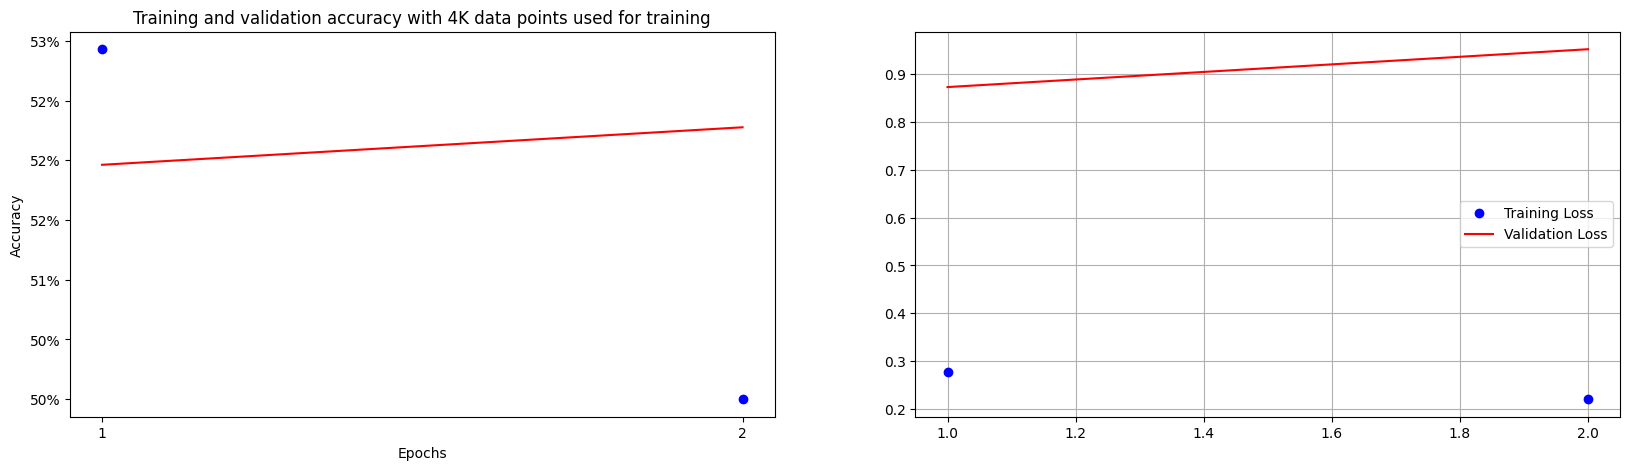

In [41]:
epochs = np.arange(2)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(epochs, epoch_accuracies, 'bo',label='Training accuracy')
plt.plot(epochs, val_epoch_accuracies, 'r',label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])

plt.subplot(122)
plt.plot(epochs,epoch_losses,'bo',label = 'Training Loss')
plt.plot(epochs,val_epoch_loss,'r',label = 'Validation Loss')
plt.legend()
plt.grid('off')
plt.show()

In [30]:
val_epoch_loss

[0.8719706535339355]